# Prey Capture in Autism-Related Rat Models: Behavioral Phenotyping of Arid1b, Grin2b, and Scn2a Strains

This tutorial shows how to access the data related to [EMBER:000204](https://dandi.emberarchive.org/dandiset/000204) using pynwb.

This dataset contains behavioral data from the prey capture experiment, part of the [Rat Behavioural Phenotyping Pipeline Methodologies](https://sidb.org.uk/facilities/rat-behavioural-phenotyping-pipeline/).


**Contents:**
- [Reading NWBFile locally](#read-nwb)
- [Access Subject Metadata](#access-subject)
- [Access Devices Metadata](#access-devices)
- [Access Behavioral Videos](#access-behavior)
- [Access USV and Detection Data](#access-usv)


# Select the subject and session to load

In [1]:
emberset_id = "000204"
session_id = "PC-TestD4"
subject_id = "252-Arid1b(1)"

# Streaming an NWB file <a id="stream-nwb"></a>

This section demonstrates how to access the files on the [EMEBER Archive](https://dandi.emberarchive.org) without downloading them. Based on the [Streaming NWB files](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html) tutorial from [PyNWB](https://pynwb.readthedocs.io/en/stable/#).

An [NWBFile](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.NWBFile) represents a single session of an experiment. Each NWBFile must have a `session description`, `identifier`, and `session start time`.

The `dandi.dandiapi.DandiAPIClient` can be used to get the S3 URL of the NWB file stored in the DANDI Archive.

In [2]:
# Import necessary modules for accessing DANDI archive
from dandi.dandiapi import DandiAPIClient, DandiInstance

dandi_instance = DandiInstance(
        "ember",
        "https://dandi.emberarchive.org",
        "https://api-dandi.emberarchive.org/api",
    )
# Create a search pattern to find the specific NWB file
pattern = (f"sub-{subject_id}/sub-{subject_id}_ses-{session_id}*.nwb")

# Initialize DANDI API client to access the archive
with DandiAPIClient(dandi_instance=dandi_instance) as client:
    # Authenticate with DANDI (required for embargoed datasets)
    # This line can be removed once the dataset is publicly available
    client.dandi_authenticate()

    # Search for assets matching our pattern in the draft version of the dandiset
    assets = client.get_dandiset(emberset_id, "draft").get_assets_by_glob(pattern=pattern, order="path")

    # Collect S3 URLs for all matching assets
    s3_urls = []
    for asset in assets:
        # Get the direct S3 URL for streaming the file
        s3_url = asset.get_content_url(follow_redirects=1, strip_query=False)
        s3_urls.append(s3_url)

    # Validate that we found exactly one matching file
    if len(s3_urls) > 1:
        raise ValueError(f"More than one asset found for pattern {pattern}")
    elif len(s3_urls) == 0:
        raise ValueError(f"No asset found for pattern {pattern}")
    else:
        # Use the single matching asset
        s3_url = s3_urls[0]
        # Get the final S3 URL for the asset
        s3_url = asset.get_content_url(follow_redirects=1, strip_query=False)

# Import modules for remote file access and NWB reading
import h5py
import remfile
from pynwb import NWBHDF5IO

# Create a remote file object that can stream data from S3
file = remfile.File(s3_url)

# Wrap the remote file in an HDF5 file object for reading
h5_file = h5py.File(file, "r")

# Create NWB IO object for reading the streamed file
io = NWBHDF5IO(file=h5_file, load_namespaces=True)

# Read the NWB file into memory for analysis
nwbfile = io.read()

# Reading an NWB file locally <a id="read-nwb"></a>

This section demonstrates how to read an NWB file using `pynwb`.

Based on the [NWB File Basics](https://pynwb.readthedocs.io/en/stable/tutorials/general/plot_file.html#sphx-glr-tutorials-general-plot-file-py) tutorial from [PyNWB](https://pynwb.readthedocs.io/en/stable/#).

An [NWBFile](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.NWBFile) represents a single session of an experiment. Each NWBFile must have a `session description`, `identifier`, and `session start time`.

Reading is carried out using the [NWBHDF5IO](https://pynwb.readthedocs.io/en/stable/pynwb.html#pynwb.NWBHDF5IO) class. To read the NWB file use the read mode ("r") to retrieve an NWBFile object.

In [ ]:
from pynwb import NWBHDF5IO
from pathlib import Path

# Define the path to the NWB file
directory = Path("D:/kind_lab_conversion_nwb/prey_capture")
nwbfile_path = directory / f"sub-{subject_id}_ses-{session_id}.nwb"
io = NWBHDF5IO(path=nwbfile_path, load_namespaces=True)
nwbfile = io.read()

In [3]:
print(nwbfile.experiment_description)

This experiment is part of the Rat Behavioural Phenotyping Pipeline Methodologies https://sidb.org.uk/facilities/rat-behavioural-phenotyping-pipeline/.
As an initial effort to characterize the rat lines, these models are being behaviorally phenotyped at SIDB.
Rat models are phenotyped according to a rigorous pipeline that assesses behaviours relevant to autism with intellectual disability, such as social and motor skills, and learning and sensory processing.
Different cohorts of rats are run through different subsets of tasks to overcome potential order effects on behaviours and to limit the number of tasks each animal is put through.
This experiment investigated prey capture behavior in different rat models
(Arid1b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394518,
Grin2b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394515,
Scn2a: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=25394530) using live crickets.
The experimenter, not present in the same roo

In [4]:
print(nwbfile.session_description)

Week 2 Experimental Day 4. Live cricket hunting.
4-5 trials per day, 2 min max duration per trial.
Rat in starting cylinder 15s, live cricket placed in opposite corner.
The rat was given 2 min to catch the cricket.
The rat was removed from the arena when the cricket was eaten or if the 2 min trial duration elapsed
(whichever happens first). Crickets were not reused.
The arena was cleared of all debris and wiped with water between trials.
Rats were held in the holding bucket between trials, the intertrial interval was approx. 1-2 min.
Ultrasonic vocalizations recorded.



Importantly, the `session start time` is the reference time for all timestamps in the file. For instance, an event with a timestamp of 0 in the file means the event occurred exactly at the session start time.

The `session_start_time` is extracted from the filename of the video during conversion.

In [5]:
print(nwbfile.session_start_time)

2022-08-11 10:39:11+01:00


# Access Subject Metadata <a name="access-subject"></a>

This section demonstrates how to access the [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field in an NWB file.

The [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field can be accessed as `nwbfile.subject`.


In [6]:
nwbfile.subject

subject pynwb.file.Subject at 0x2548046134016
Fields:
  age__reference: birth
  date_of_birth: 2022-04-13 00:00:00+02:00
  description: Subject housed in standard housing conditions. Cage identifier: 1.0.
  genotype: HET
  sex: M
  species: Rattus norvegicus
  strain: Arid1b
  subject_id: 252-Arid1b(1)

# Access Devices Metadata <a name="access-devices"></a>

This section demonstrates how to access the [Device](https://pynwb.readthedocs.io/en/stable/pynwb.device.html#module-pynwb.device) field in an NWB file.

The [Device](https://pynwb.readthedocs.io/en/stable/pynwb.device.html#module-pynwb.device) field can be accessed as `nwbfile.devices`.

In [7]:
nwbfile.devices["Arena"]

Arena pynwb.device.Device at 0x2548054340240
Fields:
  description: Square arena (100x100 cm) with 50cm high white walls and wood-lined floor
  manufacturer: Example Manufacturer

In [9]:
nwbfile.devices["camera_device 0"]

camera_device 0 abc.CameraDevice at 0x2548054333040
Fields:
  camera_name: BehavioralCamera
  description: CCTV camera mounted on ceiling above arenas for behavioral recording
  lens: Carl Zeiss lens with 20-step autofocus
  meters_per_pixel: 0.0004
  model: C920

In [10]:
nwbfile.devices["USVMicrophone"]

USVMicrophone pynwb.device.Device at 0x2548054340000
Fields:
  description: M500 USB Pettersson microphone for recording ultrasonic vocalizations, hanging approx. 1m above the arena.
  manufacturer: Pettersson, Wildlife Services UK

# Access Behavioral Video <a name="access-behavior"></a>

The behavioral videos are stored as an external `ImageSeries` in the NWB file. The number and naming of videos depend on the session type (e.g., "Hab" or habituation sessions have one video, "Test" sessions have 4-5 videos).

In [11]:
# List all behavioral video acquisitions
for name in nwbfile.acquisition:
    if "BehavioralVideo" in name:
        print(name)

BehavioralVideoTestTrial1
BehavioralVideoTestTrial2
BehavioralVideoTestTrial3
BehavioralVideoTestTrial4


In [12]:
video = nwbfile.acquisition["BehavioralVideoTestTrial1"]
video

BehavioralVideoTestTrial1 pynwb.image.ImageSeries at 0x2548054331312
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (0, 0, 0), type "|u1">
  description: Video recording of the rat's behavior. Recorded using a CCTV camera mounted on the ceiling above the chambers.

  device: camera_device 0 abc.CameraDevice at 0x2548054333040
Fields:
  camera_name: BehavioralCamera
  description: CCTV camera mounted on ceiling above arenas for behavioral recording
  lens: Carl Zeiss lens with 20-step autofocus
  meters_per_pixel: 0.0004
  model: C920

  external_file: <StrDataset for HDF5 dataset "external_file": shape (1,), type "|O">
  format: external
  interval: 1
  offset: 0.0
  resolution: -1.0
  starting_frame: [0]
  timestamps: <HDF5 dataset "timestamps": shape (2660,), type "<f8">
  timestamps_unit: seconds
  unit: Frames

The video filepath:

In [13]:
video.external_file[0]

'sub-252-Arid1b(1)_ses-PC-TestD4_image\\c4bee8bd-c7b5-48f8-8cb0-67644daf6caa_external_file_0.mp4'

The metadata of the device used to record the behavioral video:

In [14]:
video.device

camera_device 0 abc.CameraDevice at 0x2548054333040
Fields:
  camera_name: BehavioralCamera
  description: CCTV camera mounted on ceiling above arenas for behavioral recording
  lens: Carl Zeiss lens with 20-step autofocus
  meters_per_pixel: 0.0004
  model: C920

# Access USV and Detection Data <a name="access-usv"></a>

If present, USV (ultrasonic vocalization) audio files are stored in the NWB file as acquisitions:


In [15]:
# List all USV audio files
for name in nwbfile.acquisition:
    if "AcousticWaveformSeries" in name:
        print(name)

AcousticWaveformSeriesTestTrial1
AcousticWaveformSeriesTestTrial2
AcousticWaveformSeriesTestTrial3
AcousticWaveformSeriesTestTrial4


In [16]:
nwbfile.acquisition["AcousticWaveformSeriesTestTrial1"]

AcousticWaveformSeriesTestTrial1 abc.AcousticWaveformSeries at 0x2548054334144
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (22965248,), type "<i4">
  description: Ultrasonic vocalizations recorded during the trials using a Pettersson M500 USB microphone.
  offset: 0.0
  rate: 192000.0
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: n.a.

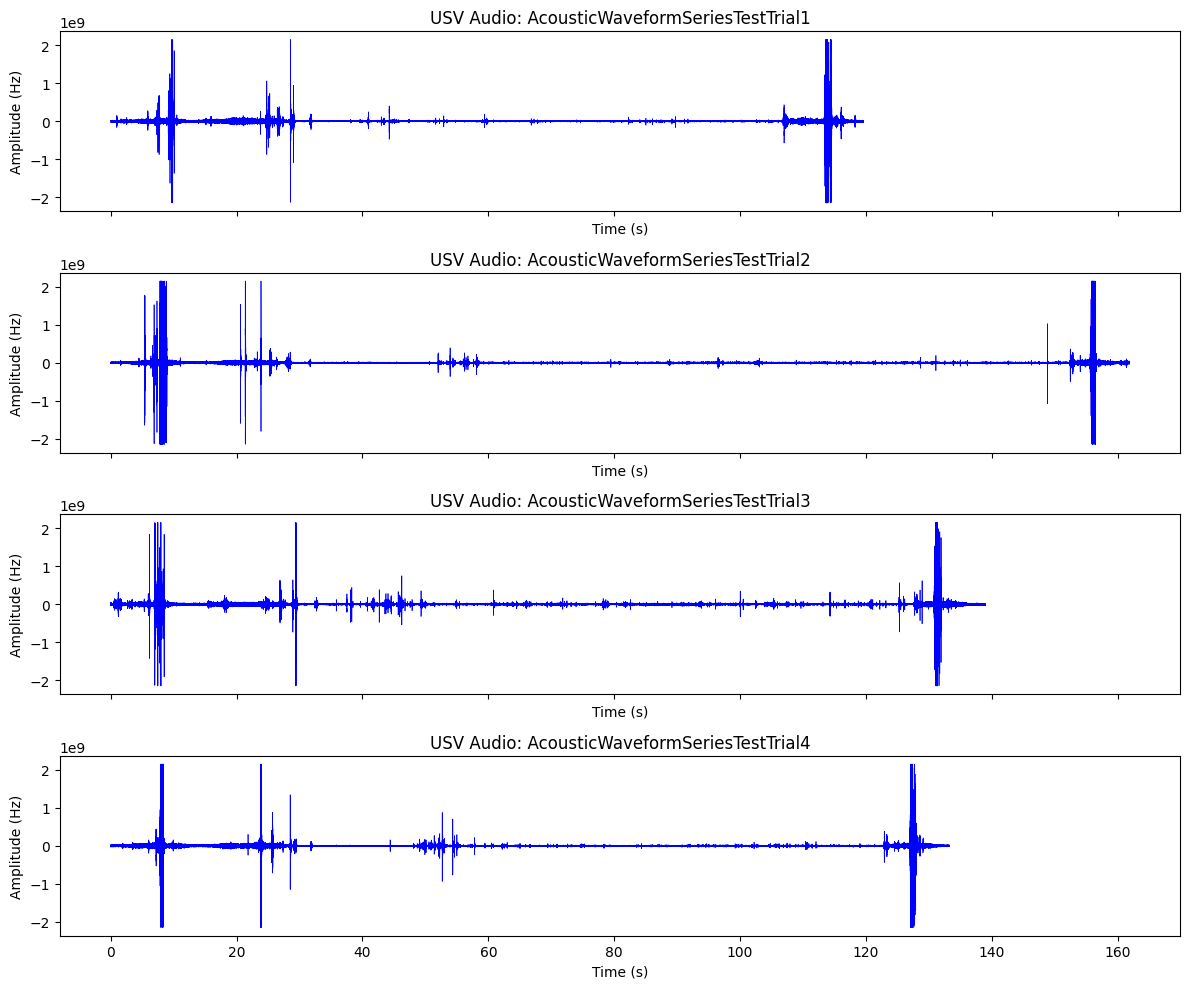

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# List all audio acquisitions
audio_keys = [key for key in nwbfile.acquisition if "AcousticWaveformSeries" in key]

# Create subplots
fig, axes = plt.subplots(len(audio_keys), 1, figsize=(12, 10), sharex=True)

if len(audio_keys) == 1:
    axes = [axes]  # Ensure axes is iterable for a single subplot

for ax, key in zip(axes, audio_keys):
    # Access the audio data and sampling rate
    audio_data = nwbfile.acquisition[key].data[:]
    sampling_rate = nwbfile.acquisition[key].rate

    # Generate time axis
    time_axis = np.arange(len(audio_data)) / sampling_rate

    # Plot the audio data
    ax.plot(time_axis, audio_data, color='blue', linewidth=0.5)
    ax.set_title(f"USV Audio: {key}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (Hz)")

plt.tight_layout()
plt.show()